In [24]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR 
#from statsmodels.tsa.vector_ar.dynamic import DynamicVAR
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

import warnings
import seaborn as sns 
from itertools import cycle
import matplotlib.pyplot as plt

%matplotlib inline 
plt.style.use('bmh')
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
warnings.filterwarnings("ignore")
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [25]:
data = pd.read_csv('SoleaTimeSeriesDataset-Temperature-Salinity.csv', usecols=['id','year_month','obs_id','salinitySurface','temperatureSurface'])
data['year_month'] = pd.to_datetime(data['year_month'])
data['year'] = data['year_month'].dt.year
data['month'] = data['year_month'].dt.month
data = data.set_index('year_month')
data.tail()

,id,obs_id,temperatureSurface,salinitySurface,year,month
year_month,,,,,,
2017-08-01,16292017-08,1629,23.582354,36.182110,2017,8
2017-09-01,16292017-09,1629,21.929382,36.138615,2017,9
2017-10-01,16292017-10,1629,19.932003,36.038403,2017,10
2017-11-01,16292017-11,1629,17.789633,36.132930,2017,11
2017-12-01,16292017-12,1629,15.722528,36.223846,2017,12


In [26]:
dataTemp = data[data['obs_id']==2][['temperatureSurface']]
dataTemp.index.freq = 'MS'

dataSal = data[data['obs_id']==2][['salinitySurface']]
dataSal.index.freq = 'MS'
dataSal.head()

,salinitySurface
year_month,
2008-01-01,38.059185
2008-02-01,37.981125
2008-03-01,38.007427
2008-04-01,37.915913
2008-05-01,37.992910


In [27]:
train_data = dataSal.iloc[:96]
test_data = dataSal.iloc[96:]

### Fitting the Model

In [28]:
span = 12
alpha = 2/(span+1)
simpleExpSmooth_model = SimpleExpSmoothing(train_data['salinitySurface']).fit(smoothing_level=alpha,optimized=False)
doubleExpSmooth_model = ExponentialSmoothing(train_data['salinitySurface'],trend='add',seasonal_periods=12).fit()
tripleExpSmooth_model = ExponentialSmoothing(train_data['salinitySurface'],trend='add',seasonal='add',seasonal_periods=12).fit()

### Evaluating Model

In [29]:
predictions_simpleExpSmooth_model = simpleExpSmooth_model.forecast(24)
predictions_doubleExpSmooth_model = doubleExpSmooth_model.forecast(24)
predictions_tripleExpSmooth_model = tripleExpSmooth_model.forecast(24)

In [30]:
predictions_tripleExpSmooth_model

2016-01-01    38.259239
2016-02-01    38.182082
2016-03-01    38.119529
2016-04-01    38.048026
2016-05-01    38.042633
2016-06-01    37.985760
2016-07-01    38.001222
2016-08-01    38.092886
2016-09-01    38.326190
2016-10-01    38.431572
2016-11-01    38.337628
2016-12-01    38.305014
2017-01-01    38.283984
2017-02-01    38.206827
2017-03-01    38.144274
2017-04-01    38.072772
2017-05-01    38.067379
2017-06-01    38.010505
2017-07-01    38.025967
2017-08-01    38.117631
2017-09-01    38.350935
2017-10-01    38.456317
2017-11-01    38.362373
2017-12-01    38.329759
Freq: MS, dtype: float64

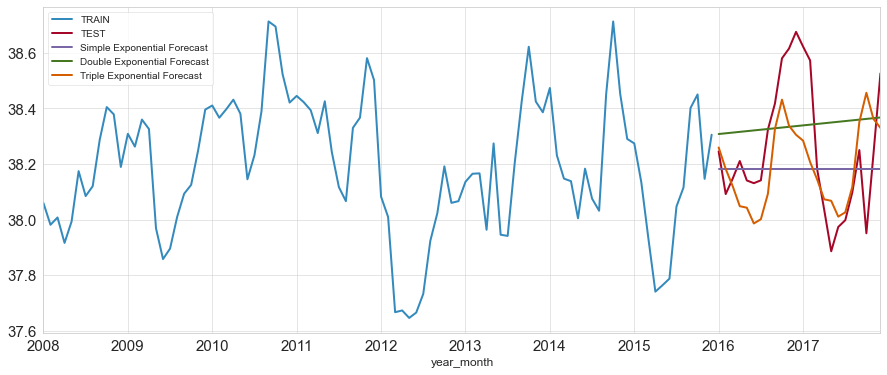

In [31]:
train_data['salinitySurface'].plot(legend=True,label='TRAIN')
test_data['salinitySurface'].plot(legend=True,label='TEST',figsize=(15,6))
predictions_simpleExpSmooth_model.plot(legend=True,label='Simple Exponential Forecast')
predictions_doubleExpSmooth_model.plot(legend=True,label='Double Exponential Forecast')
predictions_tripleExpSmooth_model.plot(legend=True,label='Triple Exponential Forecast');

### Evaluation

In [32]:
print('Simple Exponential Smoothing RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(test_data,predictions_simpleExpSmooth_model))))
print('Double Exponential Smoothing RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(test_data,predictions_doubleExpSmooth_model))))
print('Triple Exponential Smoothing RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(test_data,predictions_tripleExpSmooth_model))))

Simple Exponential Smoothing RMSE: 0.2423
Double Exponential Smoothing RMSE: 0.2491
Triple Exponential Smoothing RMSE: 0.2033


In [33]:
test_data.std()

salinitySurface    0.236641
dtype: float64

Having RMSE less than std is a good indicator for our forecasting model

## Refit model on the entire data set and forecast future unknown data

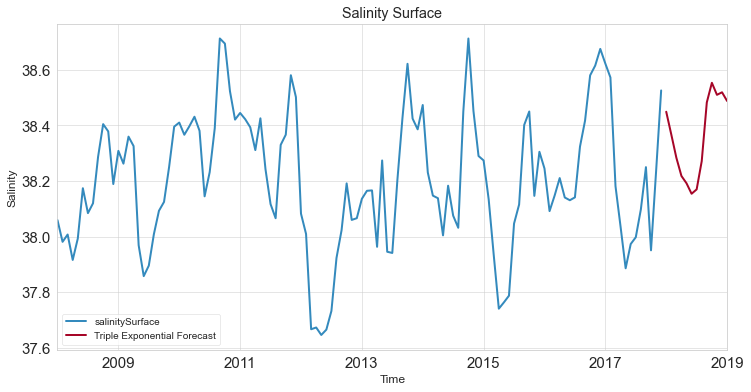

In [34]:
model = ExponentialSmoothing(dataSal['salinitySurface'],trend='add',seasonal='add',seasonal_periods=12)
results = model.fit()
fcast = results.predict(len(dataSal),len(dataSal)+12).rename('Triple Exponential Forecast')

# Plot predictions against known values
title = 'Salinity Surface'
ylabel='Salinity'
xlabel='Time'

ax = dataSal['salinitySurface'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Stationarity
Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary.
A stationary time series is one whose properties do not depend on the time at which the series is observed. 

#### Differencing
Non-stationary data can be made to look stationary through differencing. A simple differencing method calculates the difference between consecutive points.

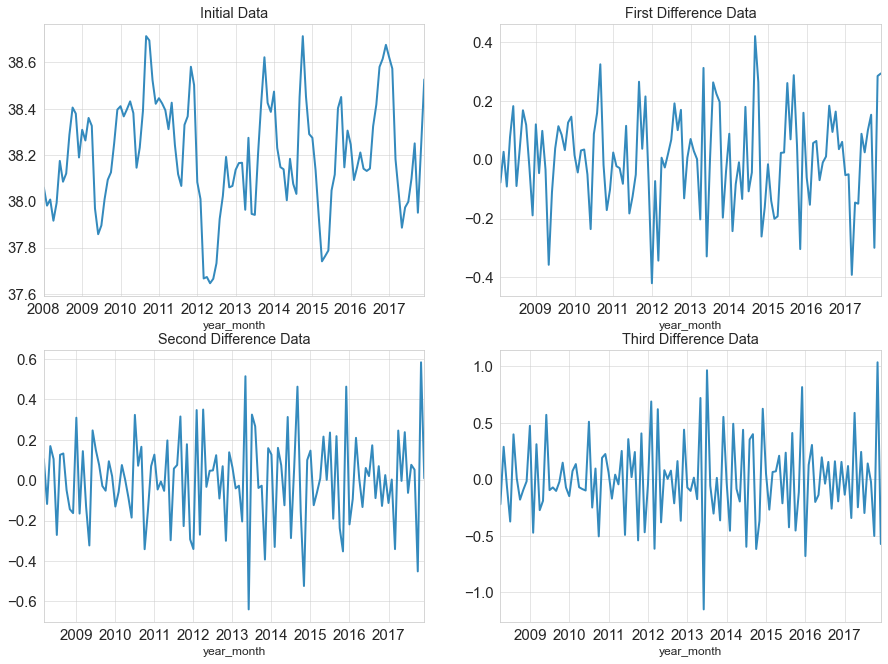

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15, 11))

dataSal['salinitySurfaceDiff1'] = diff(dataSal['salinitySurface'],k_diff=1)
dataSal['salinitySurfaceDiff2'] = diff(dataSal['salinitySurface'],k_diff=2)
dataSal['salinitySurfaceDiff3'] = diff(dataSal['salinitySurface'],k_diff=3)

dataSal['salinitySurface'].plot(title="Initial Data",ax=ax[0][0]).autoscale(axis='x',tight=True);
dataSal['salinitySurfaceDiff1'].plot(title="First Difference Data",ax=ax[0][1]).autoscale(axis='x',tight=True);
dataSal['salinitySurfaceDiff2'].plot(title="Second Difference Data",ax=ax[1][0]).autoscale(axis='x',tight=True);
dataSal['salinitySurfaceDiff3'].plot(title="Third Difference Data",ax=ax[1][1]).autoscale(axis='x',tight=True);

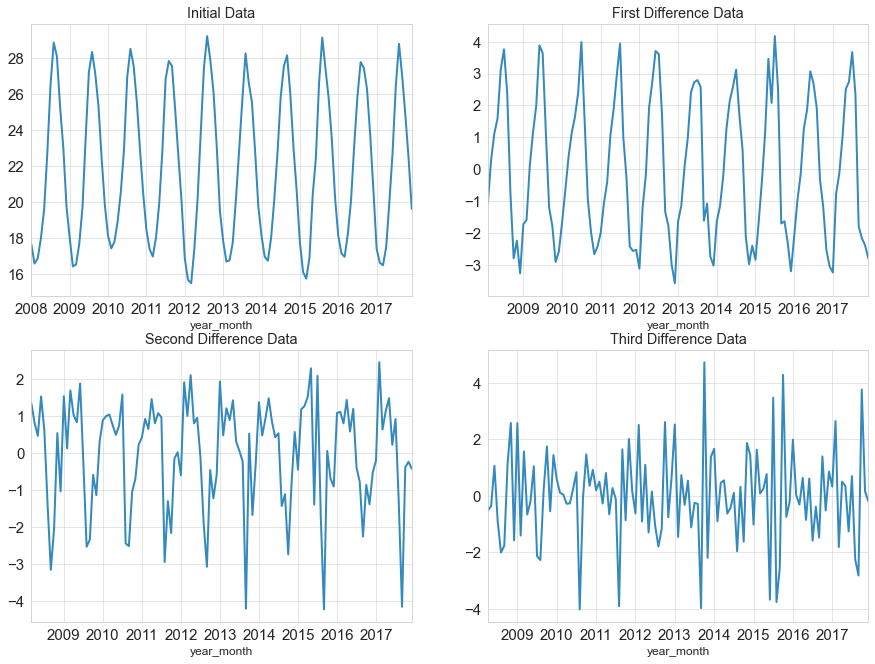

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15, 11))

dataTemp['temperatureSurfaceDiff1'] = diff(dataTemp['temperatureSurface'],k_diff=1)
dataTemp['temperatureSurfaceDiff2'] = diff(dataTemp['temperatureSurface'],k_diff=2)
dataTemp['temperatureSurfaceDiff3'] = diff(dataTemp['temperatureSurface'],k_diff=3)

dataTemp['temperatureSurface'].plot(title="Initial Data",ax=ax[0][0]).autoscale(axis='x',tight=True);
dataTemp['temperatureSurfaceDiff1'].plot(title="First Difference Data",ax=ax[0][1]).autoscale(axis='x',tight=True);
dataTemp['temperatureSurfaceDiff2'].plot(title="Second Difference Data",ax=ax[1][0]).autoscale(axis='x',tight=True);
dataTemp['temperatureSurfaceDiff3'].plot(title="Third Difference Data",ax=ax[1][1]).autoscale(axis='x',tight=True);

## ARIMA
An ARIMA model is characterized by 3 components: p, d, q
-	p is the order of the AR term. It refers to the number of lags of Y to be used as predictors.
-	q is the order of the MA term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.
-	d is the number of differencing required to make the time series stationary


### Check if Stationary

In [37]:
from statsmodels.tsa.stattools import adfuller
# check for stationarity
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [38]:
adf_test(dataSal['salinitySurface'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.525099
p-value                   0.000177
# lags used               1.000000
# observations          118.000000
critical value (1%)      -3.487022
critical value (5%)      -2.886363
critical value (10%)     -2.580009
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Automatically select ARIMA parameters

### Let's ignore the seasonality (for the sake of the example)

In [39]:
stepwise_fit = auto_arima(dataSal['salinitySurface'], start_p=0, start_q=0,
                          max_p=6, max_q=3,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
stepwise_fit.summary() 

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=2.873, BIC=8.448, Time=0.074 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-104.203, BIC=-95.841, Time=0.064 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-76.533, BIC=-68.171, Time=0.061 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=1216.856, BIC=1219.643, Time=0.006 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=-109.131, BIC=-97.981, Time=0.115 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=-108.084, BIC=-94.147, Time=0.379 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=-44.458, BIC=-30.520, Time=0.236 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-107.933, BIC=-96.783, Time=0.286 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=-104.232, BIC=-87.507, Time=0.260 seconds
Total fit time: 1.496 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  58.566
Date:                Tue, 30 Jun 2020   AIC                           -109.131
Time:                        08:44:22   BIC                            -97.981
Sample:                             0   HQIC                          -104.603
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.5449      2.640      3.994      0.000       5.370      15.720
ar.L1          0.9648      0.089     10.827      0.000       0.790       1.139
ar.L2         -0.2408      0.091     -2.659      0.008      -0.418      -0.063
sigma2         0.0218      0.003      7.739      0.000       0.016       0.027
===================================================================================
Ljung-Box (Q):                       70.66   Jarque-Bera (JB):                 0.52
Prob(Q):                              0.00   Prob(JB):                         0.77
Heteroskedasticity (H):               2.05   Skew:                            -0.15
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So we will choose an ARMA model with p(number of lags)=2 and q(size of moving window)=1
#### ARMA

In [40]:
train = dataSal.iloc[:96]
test = dataSal.iloc[96:]

In [41]:
model = ARMA(train['salinitySurface'],order=(2,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        salinitySurface   No. Observations:                   96
Model:                     ARMA(2, 1)   Log Likelihood                  47.125
Method:                       css-mle   S.D. of innovations              0.147
Date:                Tue, 30 Jun 2020   AIC                            -84.250
Time:                        08:44:26   BIC                            -71.428
Sample:                    01-01-2008   HQIC                           -79.067
                         - 12-01-2015                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    38.1938      0.045    856.083      0.000      38.106      38.281
ar.L1.salinitySurface     1.3870      0.249      5.571      0.000       0.899       1.875
ar.L2.salinitySurface    -0.5631      0.187     -3.016      0.003      -0.929      -0.197
ma.L1.salinitySurface    -0.4745      0.280     -1.695      0.090      -1.023       0.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2316           -0.5090j            1.3327           -0.0624
AR.2            1.2316           +0.5090j            1.3327            0.0624
MA.1            2.1076           +0.0000j            2.1076            0.0000
-----------------------------------------------------------------------------
"""

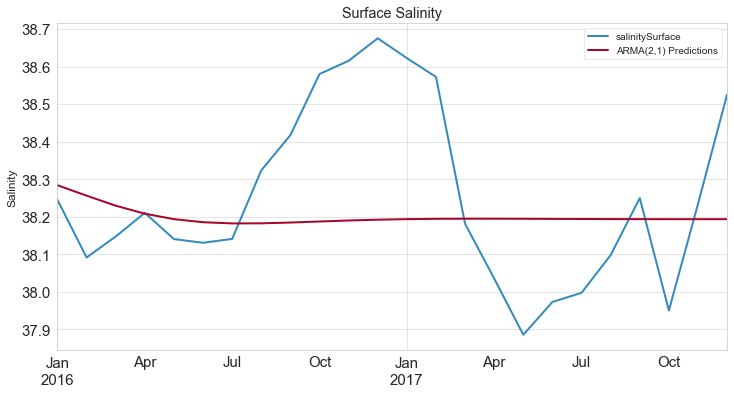

In [42]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,1) Predictions')

title = 'Surface Salinity'
ylabel='Salinity'
xlabel='' # we don't really need a label here

ax = test['salinitySurface'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Since it is an ARMA model, there is no seasonality in the predictions. For the sake of the example we chose not to search for seasonality components.

In [43]:
test['salinitySurface'].mean()

38.251985375000004

In [44]:
predictions.mean()

38.20033806152008

The model did not predict the noise, but has vary close mean to the unseen test set.

## SARIMA
It is an extension of ARIMA that accepts additional set of parameters that specifically describe the seasonal components of the model.

In [45]:
stepwise_fit = auto_arima(dataSal['salinitySurface'], start_p=0, start_q=0,
                          max_p=6, max_q=3,
                          seasonal=True, m=12,
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                         )
stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(1,0,1,12) [intercept=True]; AIC=63.598, BIC=74.748, Time=0.500 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=2.873, BIC=8.448, Time=0.029 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=-105.877, BIC=-94.727, Time=0.394 seconds
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=-75.503, BIC=-64.353, Time=0.184 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=1216.856, BIC=1219.643, Time=0.007 seconds
Fit ARIMA(1,0,0)x(0,0,0,12) [intercept=True]; AIC=-104.203, BIC=-95.841, Time=0.073 seconds
Fit ARIMA(1,0,0)x(2,0,0,12) [intercept=True]; AIC=-106.895, BIC=-92.957, Time=0.625 seconds
Fit ARIMA(1,0,0)x(2,0,1,12) [intercept=True]; AIC=426.243, BIC=442.967, Time=1.436 seconds
Fit ARIMA(1,0,0)x(1,0,1,12) [intercept=True]; AIC=188.790, BIC=202.727, Time=0.632 seconds
Near non-invertible roots for order (1, 0, 0)(1, 0, 1, 12); setting score to inf (at least one inverse root too close to the border of the

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  58.566
Date:                Tue, 30 Jun 2020   AIC                           -109.131
Time:                        08:44:41   BIC                            -97.981
Sample:                             0   HQIC                          -104.603
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.5449      2.640      3.994      0.000       5.370      15.720
ar.L1          0.9648      0.089     10.827      0.000       0.790       1.139
ar.L2         -0.2408      0.091     -2.659      0.008      -0.418      -0.063
sigma2         0.0218      0.003      7.739      0.000       0.016       0.027
===================================================================================
Ljung-Box (Q):                       70.66   Jarque-Bera (JB):                 0.52
Prob(Q):                              0.00   Prob(JB):                         0.77
Heteroskedasticity (H):               2.05   Skew:                            -0.15
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
train = dataSal.iloc[:96]
test = dataSal.iloc[96:]

In [47]:
model = SARIMAX(train['salinitySurface'],order=(1,0,0),seasonal_order=(0,1,2,12),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                         salinitySurface   No. Observations:                   96
Model:             SARIMAX(1, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -1120.074
Date:                                 Tue, 30 Jun 2020   AIC                           2248.149
Time:                                         08:44:53   BIC                           2257.872
Sample:                                     01-01-2008   HQIC                          2252.058
                                          - 12-01-2015                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7715   9.51e-22   8.12e+20      0.000       0.771       0.771
ma.S.L12    8.158e+13         -0       -inf      0.000    8.16e+13    8.16e+13
ma.S.L24    1.467e+14   2.59e-33   5.65e+46      0.000    1.47e+14    1.47e+14
sigma2      2.781e-18   2.07e-10   1.34e-08      1.000   -4.06e-10    4.06e-10
===================================================================================
Ljung-Box (Q):                       49.03   Jarque-Bera (JB):              5302.10
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -4.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [48]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('SARIMA Predictions')

title = 'Surface Temperature'
ylabel='Temperature'
xlabel='' # we don't really need a label here

ax = test['temperatureSurface'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

KeyError: 'temperatureSurface'

### Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error

error1 = mean_squared_error(test['temperatureSurface'], predictions)
error2 = rmse(test['temperatureSurface'], predictions)
print('SARIMA MSE Error: {}'.format(error))
print('SARIMA RMSE Error: {}'.format(error2))

Wow!

### Retrain the model on the full data, and forecast the future

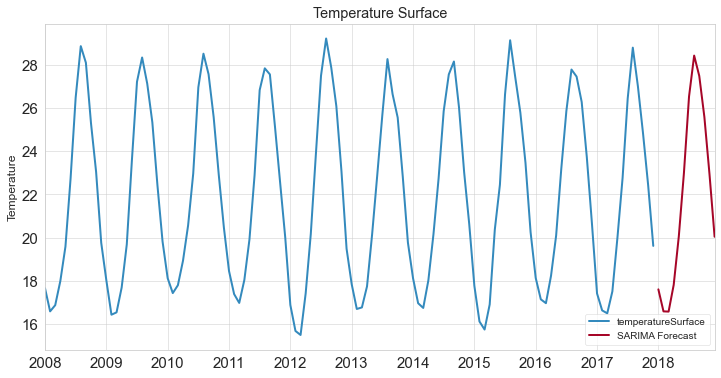

In [49]:
model = SARIMAX(dataTemp['temperatureSurface'],order=(1,0,0),seasonal_order=(0,1,1,12))
results = model.fit()
fcast = results.predict(len(dataTemp),len(dataTemp)+11,typ='levels').rename('SARIMA Forecast')

# Plot predictions against known values
title = 'Temperature Surface'
ylabel='Temperature'
xlabel=''

ax = dataTemp['temperatureSurface'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### VAR Model

In [50]:
dataSal['temperatureSurface'] = dataTemp['temperatureSurface']
data = dataSal.copy()
data = data.drop(['salinitySurfaceDiff1','salinitySurfaceDiff2','salinitySurfaceDiff3'],axis=1)
data.head()

,salinitySurface,temperatureSurface
year_month,,
2008-01-01,38.059185,17.665602
2008-02-01,37.981125,16.596148
2008-03-01,38.007427,16.882801
2008-04-01,37.915913,17.998713
2008-05-01,37.992910,19.590202


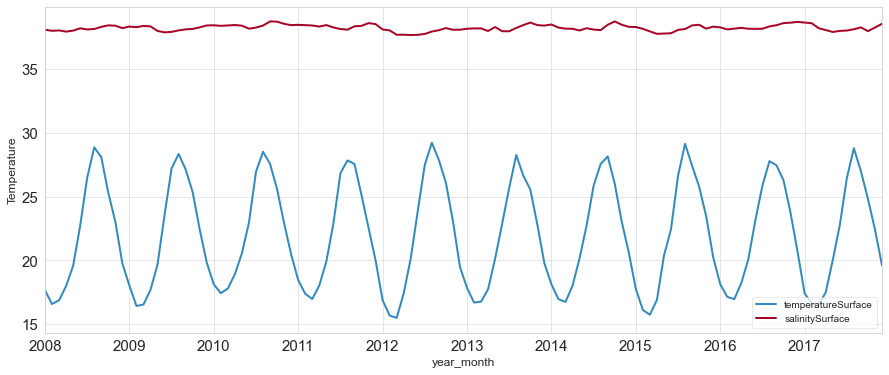

In [51]:
ax = data['temperatureSurface'].plot(figsize=(15,6),legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
data['salinitySurface'].plot(legend=True);

In [52]:
adf_test(data['temperatureSurface'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.864219
p-value                   0.049670
# lags used              10.000000
# observations          109.000000
critical value (1%)      -3.491818
critical value (5%)      -2.888444
critical value (10%)     -2.581120
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [53]:
adf_test(data['salinitySurface'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.525099
p-value                   0.000177
# lags used               1.000000
# observations          118.000000
critical value (1%)      -3.487022
critical value (5%)      -2.886363
critical value (10%)     -2.580009
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


If on series was not stationary we would have to take the forst order of difference to both series so they retain the same number of observations.

In [54]:
# train/test split
nobs=24
train, test = data[0:-nobs], data[-nobs:]

In [55]:
print(train.shape)
print(test.shape)

(96, 2)
(24, 2)


#### VAR p selection

In [56]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    #print('BIC: ', results.bic)

Order = 1
AIC:  -2.7361811751887966
Order = 2
AIC:  -4.241697962068114
Order = 3
AIC:  -4.443807385943326
Order = 4
AIC:  -4.747502698662516
Order = 5
AIC:  -4.726378890156052
Order = 6
AIC:  -4.82586150309009
Order = 7
AIC:  -4.945404419388462
Order = 8
AIC:  -4.932371512064865
Order = 9
AIC:  -4.887289014149976
Order = 10
AIC:  -4.865728565066896


We choose order of 8.

In [57]:
results = model.fit(7)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 30, Jun, 2020
Time:                     08:46:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.10654
Nobs:                     89.0000    HQIC:                  -4.60728
Log likelihood:          -2.50056    FPE:                 0.00716240
AIC:                     -4.94540    Det(Omega_mle):      0.00524532
--------------------------------------------------------------------
Results for equation salinitySurface
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         6.915573         3.463010            1.997           0.046
L1.salinitySurface            0.791693         0.115707            6.842           0.000
L1.temperatureSurf

In [58]:
lag_order = results.k_ar
z = results.forecast(y=train.values[-lag_order:], steps=nobs)
z

array([[38.32637099, 17.75625094],
       [38.15591943, 16.08599521],
       [38.1454916 , 15.97763975],
       [38.06493327, 17.37887336],
       [37.96986067, 20.31942252],
       [37.95596651, 23.77079944],
       [38.04039492, 26.41271499],
       [38.16813215, 27.86140944],
       [38.24414064, 27.73221469],
       [38.32245915, 26.07956438],
       [38.36783123, 23.41688121],
       [38.35661989, 20.31627545],
       [38.31957798, 17.62021428],
       [38.23789417, 16.04978312],
       [38.13499874, 16.08340787],
       [38.0450288 , 17.740404  ],
       [37.99592021, 20.50506848],
       [38.00699473, 23.6256956 ],
       [38.06356606, 26.25802591],
       [38.15141107, 27.7136347 ],
       [38.24741421, 27.63770972],
       [38.325937  , 26.0425546 ],
       [38.37151436, 23.34982661],
       [38.36919114, 20.27366132]])

In [59]:
test

,salinitySurface,temperatureSurface
year_month,,
2016-01-01,38.245030,18.143910
2016-02-01,38.091680,17.152920
2016-03-01,38.147560,16.974339
2016-04-01,38.210617,18.242626
2016-05-01,38.140694,20.103613
2016-06-01,38.130856,23.170494
2016-07-01,38.141140,25.857565
2016-08-01,38.323765,27.776896
2016-09-01,38.417522,27.450100


In [60]:
idx = pd.date_range('1/1/2016', periods=nobs, freq='MS')
df_forecast = pd.DataFrame(z, index=idx, columns=['salinitySurfaceForecast','temperatureSurfaceForecast'])
df_forecast

,salinitySurfaceForecast,temperatureSurfaceForecast
2016-01-01,38.326371,17.756251
2016-02-01,38.155919,16.085995
2016-03-01,38.145492,15.977640
2016-04-01,38.064933,17.378873
2016-05-01,37.969861,20.319423
2016-06-01,37.955967,23.770799
2016-07-01,38.040395,26.412715
2016-08-01,38.168132,27.861409
2016-09-01,38.244141,27.732215
2016-10-01,38.322459,26.079564


#### If we had differenced columns than we have to invert the transformation

In [61]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
#df_forecast['temperatureSurface1d'] = (data['temperatureSurface'].iloc[-nobs-1]-data['temperatureSurface'].iloc[-nobs-2]) + df_forecast['temperatureSurface2d'].cumsum()

# Now build the forecast values from the first difference set
#df_forecast['temperatureSurfaceForecast'] = data['temperatureSurface'].iloc[-nobs-1] + df_forecast['temperatureSurface1d'].cumsum()

In [62]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
#df_forecast['salinitySurface1d'] = (data['salinitySurface'].iloc[-nobs-1]-data['salinitySurface'].iloc[-nobs-2]) + df_forecast['salinitySurface2d'].cumsum()

# Now build the forecast values from the first difference set
#df_forecast['salinitySurfaceForecast'] = data['salinitySurface'].iloc[-nobs-1] + df_forecast['salinitySurface1d'].cumsum()

In [63]:
df_forecast

,salinitySurfaceForecast,temperatureSurfaceForecast
2016-01-01,38.326371,17.756251
2016-02-01,38.155919,16.085995
2016-03-01,38.145492,15.977640
2016-04-01,38.064933,17.378873
2016-05-01,37.969861,20.319423
2016-06-01,37.955967,23.770799
2016-07-01,38.040395,26.412715
2016-08-01,38.168132,27.861409
2016-09-01,38.244141,27.732215
2016-10-01,38.322459,26.079564


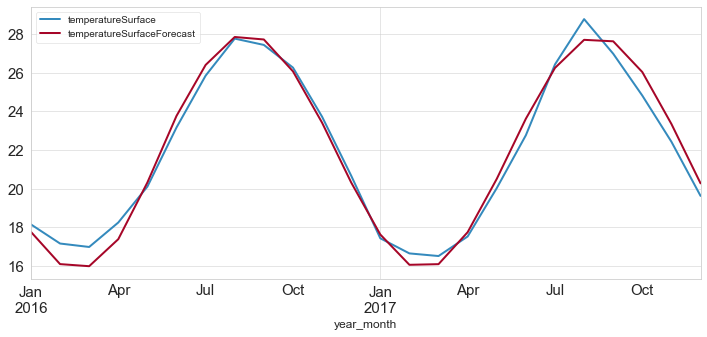

In [64]:
data['temperatureSurface'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['temperatureSurfaceForecast'].plot(legend=True);

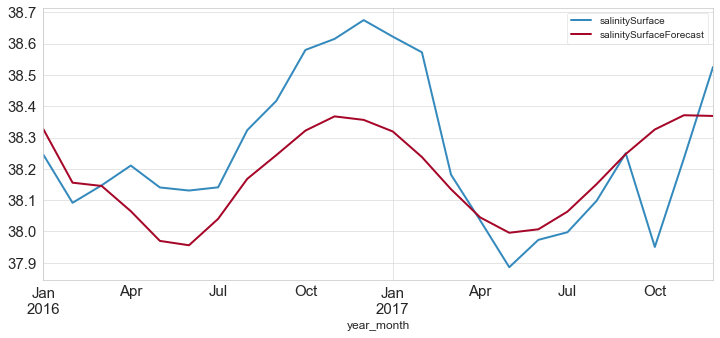

In [65]:
data['salinitySurface'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['salinitySurfaceForecast'].plot(legend=True);

In [66]:
from sklearn.metrics import mean_squared_error

error1 = mean_squared_error(test['temperatureSurface'], df_forecast['temperatureSurfaceForecast'])
error2 = rmse(test['temperatureSurface'], predictions)
print('VAR Temperature MSE Error: {}'.format(error1))
print('VAR RMSE Error: {}'.format(error2))

VAR Temperature MSE Error: 0.4181685903104769
VAR RMSE Error: 16.444626614021026


In [67]:
from sklearn.metrics import mean_squared_error

error1 = mean_squared_error(test['salinitySurface'], df_forecast['salinitySurfaceForecast'])
error2 = rmse(test['salinitySurface'], predictions)

print('VAR Salinity MSE Error: {}'.format(error1))
print('VAR RMSE Error: {}'.format(error2))

VAR Salinity MSE Error: 0.033194628496844965
VAR RMSE Error: 0.4679126096012445


### VARMA Model

In [68]:
data.head()

,salinitySurface,temperatureSurface
year_month,,
2008-01-01,38.059185,17.665602
2008-02-01,37.981125,16.596148
2008-03-01,38.007427,16.882801
2008-04-01,37.915913,17.998713
2008-05-01,37.992910,19.590202


In [69]:
auto_arima(data['salinitySurface'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(2, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [70]:
auto_arima(data['temperatureSurface'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(2, 0, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [71]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    for j in [1,2,3,4,5,6,7,8,9,10]:
        model = VARMAX(train, order=(i,j), trend='c')
        results = model.fit()
        print('Order =', i,j)
        print('AIC: ', results.aic)
        #print('BIC: ', results.bic)

Order = 1 1
AIC:  226.87014310756987
Order = 1 2
AIC:  238.12751599916555
Order = 1 3
AIC:  257.2915369276458
Order = 1 4
AIC:  255.8170236648493
Order = 1 5
AIC:  259.60764238716126
Order = 1 6
AIC:  258.5101564112674
Order = 1 7
AIC:  411.14227588999915
Order = 1 8
AIC:  277.7084495924196
Order = 1 9
AIC:  289.6475981733325
Order = 1 10
AIC:  304.88578328484846
Order = 2 1
AIC:  136.44929912684444
Order = 2 2
AIC:  124.25724287439704
Order = 2 3
AIC:  128.46206706692342
Order = 2 4
AIC:  144.06414275109844


LinAlgError: LU decomposition error.

In [ ]:
model = VARMAX(train, order=(2,2), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

In [ ]:
df_forecast = results.forecast(24)
df_forecast

In [ ]:
data['temperatureSurface'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['temperatureSurface'].plot(legend=True);

In [ ]:
data['salinitySurface'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['salinitySurface'].plot(legend=True);

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['temperatureSurface'], df_forecast['temperatureSurface'])
print('VAR Temperature MSE Error: {}'.format(error))

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['salinitySurface'], df_forecast['salinitySurface'])
print('VAR Salinity MSE Error: {}'.format(error))